In [ ]:
# print out the coverage rate for all 5-node & 6-node patterns for all possible hyper-tree decomposition

import os
import networkx as nx
from networkx.algorithms.approximation import treewidth
from networkx.algorithms.approximation.treewidth import treewidth_min_degree
from itertools import combinations
import matplotlib.pyplot as plt
from pynauty import Graph, autgrp

def nx_to_nauty(G):
    ngraph = Graph(number_of_vertices=len(G.nodes()))
    for u, v in G.edges():
        ngraph.connect_vertex(u, v)
    return ngraph

def is_valid_group(G, group):
    # A group is valid if no two nodes in the group are connected
    for node1, node2 in combinations(group, 2):
        if G.has_edge(node1, node2):
            return False
    return True

def find_all_partitions(G, nodes, current_partition, all_partitions):
    if not nodes:
        all_partitions.append(current_partition)
        return
    
    first_node = nodes[0]
    remaining_nodes = nodes[1:]

    for i in range(len(current_partition)):
        new_group = current_partition[i] | {first_node}
        if is_valid_group(G, new_group):
            find_all_partitions(G, remaining_nodes, current_partition[:i] + [new_group] + current_partition[i+1:], all_partitions)

    # Start a new group with the first node
    find_all_partitions(G, remaining_nodes, current_partition + [{first_node}], all_partitions)

def get_all_partitions(G):
    nodes = list(G.nodes())
    all_partitions = []
    find_all_partitions(G, nodes, [], all_partitions)
    return all_partitions

def is_covered(decomposition, partition):
    for bag in decomposition:
        if len(bag) <= 1:
            continue
        for group in partition:
            if len(group) <= 1:
                continue
            if len(group.intersection(bag)) >= 2:
                return False
    return True

def load_pattern(pattern_dir):
    patterns = {} # {'file_name': pattern}
    for file in os.listdir(pattern_dir):
        path = os.path.join(pattern_dir, file)
        with open(path, "r") as f:
            pattern = nx.Graph()
            num_v, _ = map(int, f.readline().strip().split())
            pattern.add_nodes_from(range(0, num_v))
            for line in f.readlines()[:-1]:
                u, v = line.strip().split()
                pattern.add_edge(int(u), int(v))
        patterns[os.path.splitext(file)[0]] = pattern
    return patterns

def compute_coverage_rate(pattern, verbose=False):
    # print the pattern graph
    if verbose:
        nx.draw(pattern, with_labels=True)
        plt.show()

    # compute tree decomposition with the tree width
    tw, decomposition = treewidth_min_degree(pattern)
    if verbose:
        print("True Treewidth:", tw)
        print("True Tree decomposition:")
        for i, bag in enumerate(decomposition.nodes):
            print(f"Bag {i}: {bag}")
        print()

    # compute possible homorphism sub-pattern of the pattern
    partitions = get_all_partitions(pattern)

    # print all sub-patterns
    for i, partition in enumerate(partitions):
        if verbose:
            print(f"Partition {i+1}: {partition}")

            # draw this patition
            partition_graph = nx.Graph()
            partition_graph.add_nodes_from(range(0, len(partition)))
            for index_1, group_1 in enumerate(partition):
                for index_2, group_2 in enumerate(partition):
                    if group_1 == group_2:
                        continue
                    find_edge = False
                    for node_1 in group_1:
                        for node_2 in group_2:
                            if pattern.has_edge(node_1, node_2):
                                partition_graph.add_edge(index_1, index_2)
                                find_edge = True
                                break
                        if find_edge:
                            break
            nx.draw(partition_graph, with_labels=True)
            plt.show()
    # compute the number of partitions that can be covered
    coverage = 0
    for partition in partitions:
        if is_covered(decomposition, partition):
            coverage += 1
    if verbose:
        print(f"Coverage rate: {coverage}/{len(partitions)}")
    
    if verbose:
        generators, grpsize1, grpsize2, orbits, numorbits = autgrp(nx_to_nauty(pattern))
        print(pattern.nodes())
        for auto in generators:
            print(auto)
        print(grpsize1, grpsize2, orbits, numorbits)

    return coverage, len(partitions), tw

if __name__ == "__main__":

    # create the pattern
    # pattern = nx.Graph()
    # pattern.add_nodes_from([1, 2, 3, 4, 5, 6])
    # pattern.add_edges_from([(1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (3, 4), (4, 5), (2, 6), (3, 6), (4, 6), (5, 6)])

    # load all 5voc, 6voc
    voc5_dir = "exp/pattern_graph/5voc"
    voc6_dir = "exp/pattern_graph/6voc"
    voc5_patterns = load_pattern(voc5_dir)
    voc6_patterns = load_pattern(voc6_dir)

    # compute the coverage rate for all patterns
    info = []
    for name, pattern in voc5_patterns.items():
        coverage, total, tw = compute_coverage_rate(pattern, verbose=True if name =='30' else False)
        info.append((name, coverage, total, tw))

In [ ]:
# find out the file of the pattern in the paper
import networkx as nx
import os

def load_pattern(pattern_dir):
    patterns = {} # {'file_name': pattern}
    for file in os.listdir(pattern_dir):
        path = os.path.join(pattern_dir, file)
        with open(path, "r") as f:
            pattern = nx.Graph()
            num_v, _ = map(int, f.readline().strip().split())
            pattern.add_nodes_from(range(0, num_v))
            for line in f.readlines()[:-1]:
                u, v = line.strip().split()
                pattern.add_edge(int(u), int(v))
        patterns[os.path.splitext(file)[0]] = pattern
    return patterns


if __name__ == "__main__":
    # create the pattern
    pattern = nx.Graph()
    pattern.add_nodes_from([1, 2, 3, 4, 5, 6])
    pattern.add_edges_from([(1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (3, 4), (4, 5), (2, 6), (3, 6), (4, 6), (5, 6)])

    # pattern = nx.Graph()
    # pattern.add_nodes_from([0, 1, 2, 3, 4])
    # pattern.add_edges_from([(0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (3, 4)])

    # pattern = nx.Graph()
    # pattern.add_nodes_from([0, 1, 2, 3, 4])
    # pattern.add_edges_from([(0, 1), (0, 2), (0, 3), (0, 4), (1, 3), (1, 2), (2, 3), (3, 4)])
    
    voc5_dir = "exp/pattern_graph/5voc"
    voc6_dir = "exp/pattern_graph/6voc"
    
    patterns = load_pattern(voc6_dir)

    # traverse all patterns and find the iso-match pattern in the paper
    for name, p in patterns.items():
        if nx.is_isomorphic(pattern, p):
            print(name)


In [ ]:
# program to compute the left cosets
from itertools import permutations

def parse_permutation(perm_str):
    """Parses a permutation string like '(1)(2,3,4)(5)' into a permutation dict."""
    perm = {}
    cycles = perm_str.split(')(')
    for cycle in cycles:
        cycle = cycle.replace('(', '').replace(')', '')
        elements = list(map(int, cycle.split(',')))
        for i in range(len(elements)):
            perm[elements[i]] = elements[(i + 1) % len(elements)]
    return perm

def apply_permutation(perm, element):
    """Applies a permutation to a single element."""
    return perm.get(element, element)

def multiply_permutations(perm1, perm2):
    """Multiplies two permutations (perm2 followed by perm1)."""
    result = {}
    all_keys = set(perm1.keys()).union(set(perm2.keys()))
    for key in all_keys:
        result[key] = apply_permutation(perm1, apply_permutation(perm2, key))
    return result

def format_permutation(perm):
    """Formats a permutation dict back into cycle notation."""
    seen = set()
    cycles = []
    for key in perm.keys():
        if key not in seen:
            current = key
            cycle = []
            while current not in seen:
                seen.add(current)
                cycle.append(current)
                current = perm[current]
            if len(cycle) >= 1:
                cycles.append('(' + ','.join(map(str, cycle)) + ')')
    return ''.join(cycles)

# Example usage
if __name__ == "__main__":
    group = ['(1)(2)(3)(4)(5)', '(1)(2,3,4)(5)', '(1)(2,4,3)(5)', '(1)(2,3)(4)(5)', '(1)(2,4)(3)(5)', '(1)(2)(3,4)(5)',
             '(1,5)(2)(3)(4)', '(1,5)(2,3,4)', '(1,5)(2,4,3)', '(1,5)(2,3)(4)', '(1,5)(2,4)(3)', '(1,5)(2)(3,4)']
    stabilizers = ['(1)(2)(3)(4)(5)', '(1)(2)(3,4)(5)', '(1,5)(2)(3)(4)', '(1,5)(2)(3,4)']

    group_parsed = [parse_permutation(perm) for perm in group]
    stabilizers_parsed = [parse_permutation(perm) for perm in stabilizers]
    result = []
    for g in group_parsed:
        cosets = []
        for stabilizer in stabilizers_parsed:
            cosets.append(format_permutation(multiply_permutations(g, stabilizer)))
        cosets.sort()
        if cosets not in result:
            result.append(cosets)
    for cosets in result:
        # subsutitute the permutation with the index + 1 in group array
        cosets = [group.index(perm) + 1 for perm in cosets]
        cosets.sort()
        print(cosets)

In [ ]:
# verify if the outputs from SCOPE can match the results from the SubgraphMatching program
import os
import pynauty as nauty


def load_pattern(pattern_path):
    with open(pattern_path, "r") as f:
        vertex_num, edge_num = map(int, f.readline().strip().split())
        graph = nauty.Graph(number_of_vertices=int(vertex_num))
        for _ in range(edge_num):
            line = f.readline()
            graph.connect_vertex(*map(int, line.strip().split()))
        selected_vertex = int(f.readline().strip().split()[-1])
    return graph, selected_vertex

if __name__ == "__main__":
    # name of the data graph
    data_graph = "web-spam"
    pattern_size = "7"
    prefix_path = "/home/ubuntu/Documents/workspace/dataset"
    # SCOPE directory
    scope_dir = "{}/{}/{}voc/".format(prefix_path, data_graph, pattern_size)

    # Subgraph Matching directory
    subgraph_matching_dir = "{}/iso_outputs_SubgraphMatch/{}/".format(prefix_path, data_graph)

    # pattern directory
    pattern_dir = "{}/patterns/{}voc/".format(prefix_path, pattern_size)

    # data structures to store the results
    scope_pattern_lsc = {} # {'pattern_name': [count, ...], ...}
    subgraph_matching_pattern_lsc = {} # {'pattern_name': {count, ...}, ...}

    # load the LSC results from the SCOPE directory
    for file in os.listdir(scope_dir):
        path = os.path.join(scope_dir, file)
        with open(path, "r") as f:
            countings = []
            for line in f.readlines():
                countings.append(int(line.strip()))
            scope_pattern_lsc[os.path.splitext(file)[0]] = countings

    # load the LSC results from the Subgraph Matching directory
    for file in os.listdir(subgraph_matching_dir):
        if not file.startswith(str(pattern_size)):
            continue
        path = os.path.join(subgraph_matching_dir, file)
        with open(path, "r") as f:
            countings = []
            for line in f.readlines():
                if line.startswith("Vertex"):
                    countings.append(int(line.strip().split(":")[-1]))
            subgraph_matching_pattern_lsc[os.path.splitext(file)[0].split('_')[-1]] = countings

    if len(scope_pattern_lsc) != len(subgraph_matching_pattern_lsc):
        print("Error: The number of patterns from SCOPE and Subgraph Matching are different")
        exit(1)

    # obtain the automorphisms and orbits of the all patterns
    automorphisms = {} # {'pattern_name': automorphisms_num, ...}
    orbits = {} # {'pattern_name': {vertex_id, orbits_size}, ...}

    # iterate the LSC results for each pattern
    for pattern_name in scope_pattern_lsc.keys():
        scope_counts = scope_pattern_lsc[pattern_name]
        subgraph_matching_counts = subgraph_matching_pattern_lsc[pattern_name]

        # load the pattern graph
        pattern, selected_vertex = load_pattern(os.path.join(pattern_dir, pattern_name + ".txt"))

        # compute the autormorphisms and orbits of the iterated pattern
        generators, grpsize1, grpsize2, orbits, numorbits  = nauty.autgrp(pattern)
        automorphisms_grp_size = int(grpsize1 * (10**grpsize2))
        selected_vertex_orbit_label = orbits[selected_vertex]
        selected_vertex_orbits_grp_size = 0
        for orbit in orbits:
            if orbit == selected_vertex_orbit_label:
                selected_vertex_orbits_grp_size += 1
        
        for scope_count, subgraph_matching_count in zip(scope_counts, subgraph_matching_counts):
            # compare the results from SCOPE and Subgraph Matching for the iterated pattern
            if scope_count != int(subgraph_matching_count * selected_vertex_orbits_grp_size / automorphisms_grp_size):
                print("Error: The results of SCOPE and Subgraph Matching are different")
                exit(1)

In [ ]:
# convert from a labeled graph to a unlabeled graph
if __name__ == "__main__":
    prefix = "/home/ubuntu/Documents/workspace"
    data_graph = "youtube"
    src_path = "{}/dataset/{}/data_graph/{}.graph".format(prefix, data_graph, data_graph)
    dst_scope_path = "{}/subgraph-counting/exp/data_graph/{}.txt".format(prefix, data_graph)
    dst_light_path = "{}/LIGHT/sample_graph/{}.edge_list".format(prefix, data_graph)

    # read the edges from the src file
    edges = []
    num_vertices = 0
    num_edges = 0
    with open(src_path, "r") as f:
        for line in f.readlines():
            if line.startswith("e"):
                src, dest = map(int, line.strip().split()[1:3])
                if src > num_vertices:
                    num_vertices = src
                if dest > num_vertices:
                    num_vertices = dest
                edges.append([src, dest])
    num_edges = len(edges)
    num_vertices += 1

    # print the number of vertices and edges
    print(num_vertices, num_edges)

    # write the edges to the dst file
    with open(dst_scope_path, "w") as f:
        f.write("{} {}\n".format(num_vertices, num_edges))
        for edge in edges:
            f.write("{} {}\n".format(edge[0], edge[1]))
    
    # with open(dst_light_path, "w") as f:
    #     for edge in edges:
    #         f.write("{} {}\n".format(edge[0], edge[1]))

In [ ]:
# convert an unlabeled graph to a two-core only graph

import networkx as nx

# Function to extract the 2-core
def extract_2_core(G):
    return nx.k_core(G, k=2)

# Function to write the new edge list to a file
def write_edge_list(G, file_path):
    with open(file_path, 'w') as f:
        for edge in G.edges():
            f.write(f"{edge[0]} {edge[1]}\n")

if __name__ == "__main__":
    prefix = "/home/ubuntu/Documents/workspace/subgraph-counting/exp/data_graph"
    data_graph = "youtube"
    src_path = "{}/{}.txt".format(prefix, data_graph)
    dst_path = "{}/{}_two_core.txt".format(prefix, data_graph)

    graph = nx.read_edgelist(src_path, nodetype=int)
    graph_core_2 = nx.k_core(graph, k=2)

    mapping = {old_label: new_label for new_label, old_label in enumerate(graph_core_2.nodes())}
    G_continuous = nx.relabel_nodes(graph_core_2, mapping)
    
    with open(dst_path, 'w') as f:
        f.write(f"{G_continuous.number_of_nodes()} {G_continuous.number_of_edges()}\n")
        for edge in G_continuous.edges():
            f.write(f"{edge[0]} {edge[1]}\n")

In [1]:
# convert a edge list txt from 1-based to 0-based

def convert_to_zero_based(input_file, output_file):
    with open(input_file, 'r') as infile:
        # Read the first line which contains the number of vertices and edges
        num_vertices, num_edges = map(int, infile.readline().split())

        # Read the remaining lines which contain the edges
        edges = []
        for line in infile:
            u, v = map(int, line.split())
            # Convert to zero-based index by subtracting 1 from each vertex
            edges.append((u - 1, v - 1))

    # Write the modified graph to the output file
    with open(output_file, 'w') as outfile:
        # Write the number of vertices and edges
        outfile.write(f"{num_vertices} {num_edges}\n")
        # Write the modified edges
        for u, v in edges:
            outfile.write(f"{u} {v}\n")

if __name__ == "__main__":
    # Replace 'input.txt' with the path to your input file
    # Replace 'output.txt' with the path where you want to save the output
    input_file = './exp/data_graph/soc-gowalla.txt'
    output_file = './exp/data_graph/soc-gowalla-new.txt'
    convert_to_zero_based(input_file, output_file)


In [ ]:
# find all patterns that use only executeTree as the counting method

import os

def is_all_function_calls_execute_tree(function_calls):
    if len(function_calls) == 0:
        return False
    for function_call in function_calls:
        if function_call != "execute tree":
            return False
    return True

def print_executed_tree_patterns(folder, file_path):
    valid_region = False
    function_calls = []
    with open(file_path, "r") as f:
        for line in f.readlines():
            if line.startswith("finished building edge "):
                valid_region = True
                continue
            if line.startswith("compute equation time"):
                valid_region = False
            if valid_region:
                if line.startswith("file:"):
                    if not is_all_function_calls_execute_tree(function_calls):
                        print(folder + "_" + line.strip().split(",")[0].split(":")[1].strip())
                    function_calls = []
                else:
                    function_calls.append(line.strip())

if __name__ == "__main__":
    prefix = "/home/ubuntu/Documents/workspace/subgraph-counting/result/web-spam"
    folders = ["5voc", "6voc", "7voc"]
    for folder in folders:
        print("Folder: ", folder)
        print("====================================")
        path = "{}/{}".format(prefix, folder)
        for file in os.listdir(path):
            if file.endswith("_outputs.txt"):
                file_path = os.path.join(path, file) 
                print_executed_tree_patterns(folder, file_path)

In [14]:
# copy patterns from 5voc, 6voc and 7voc to a new directory
# the copied patterns should with a prefix e.g.: 5voc_17.txt, 6voc_1.txt, ...
import shutil
import os

if __name__ == "__main__":
    prefix = "/home/ubuntu/Documents/workspace/subgraph-counting/exp/pattern_graph"
    folders = ["5voc", "6voc", "7voc"]
    for folder in folders:
        path = "{}/{}".format(prefix, folder)
        for file in os.listdir(path):
            if file.endswith(".txt"):
                shutil.copyfile(os.path.join(path, file), os.path.join(prefix, "all", folder + "_" + file))

In [19]:
# remove certain files from a folder:
files_to_be_removed = [
    "5voc_72.txt",
    "5voc_71.txt",
    "5voc_70.txt",
    "5voc_69.txt",
    "5voc_68.txt",
    "5voc_55.txt",
    "5voc_54.txt",
    "5voc_50.txt",
    "5voc_49.txt",
    "5voc_23.txt",
    "5voc_22.txt",
    "6voc_95.txt",
    "6voc_94.txt",
    "6voc_93.txt",
    "6voc_92.txt",
    "6voc_91.txt",
    "6voc_406.txt",
    "6voc_405.txt",
    "6voc_372.txt",
    "6voc_371.txt",
    "6voc_370.txt",
    "6voc_365.txt",
    "6voc_364.txt",
    "6voc_363.txt",
    "6voc_362.txt",
    "6voc_361.txt",
    "6voc_360.txt",
    "6voc_359.txt",
    "6voc_26.txt",
    "6voc_162.txt",
    "6voc_161.txt",
    "6voc_150.txt",
    "6voc_147.txt",
    "6voc_103.txt",
    "6voc_102.txt",
    "6voc_101.txt",
    "6voc_100.txt"
]
dir_path = "/home/ubuntu/Documents/workspace/subgraph-counting/exp/pattern_graph/executed_tree_patterns"
for file in files_to_be_removed:
    os.remove(os.path.join(dir_path, file))

In [ ]:
# verify the correctness of the results from the scope-parallel
import os

if __name__ == "__main__":
    prefix_path = "/home/ubuntu/Documents/workspace/subgraph-counting/result"

    # data structures to store the single-thread lsc results
    single_thread_lsc = {} # {'pattern_name': [count, ...], ...}
    multi_thread_lsc = {}

    # single-thread directory
    for folder in ["5voc", "6voc", "7voc"]:
        single_thread_dir = "{}/soc-gowalla-single/{}".format(prefix_path, folder)
        for file in os.listdir(single_thread_dir):
            if not file.endswith("outputs.txt"):
                path = os.path.join(single_thread_dir, file)
                with open(path, "r") as f:
                    countings = []
                    for line in f.readlines():
                        countings.append(int(line.strip()))
                    single_thread_lsc[folder + "_" + os.path.splitext(file)[0]] = countings
    print(len(single_thread_lsc))
    
    # multi-thread directory
    multi_thread_dir = "{}/soc-gowalla-parallel/".format(prefix_path)
    for file in os.listdir(multi_thread_dir):
        if not file.endswith("outputs.txt"):
            path = os.path.join(multi_thread_dir, file)
            with open(path, "r") as f:
                countings = []
                for line in f.readlines():
                    countings.append(int(line.strip()))
                multi_thread_lsc[os.path.splitext(file)[0]] = countings
    print(len(multi_thread_lsc))
    
    for pattern_name in multi_thread_lsc:
        if pattern_name not in single_thread_lsc:
            print("Error: The pattern {} does not exist in the single-thread results".format(pattern_name))
            exit(1)
        if len(multi_thread_lsc[pattern_name]) != len(single_thread_lsc[pattern_name]):
            print("Error: The number of counts for the pattern {} is different".format(pattern_name))
            exit(1)
        for i in range(len(multi_thread_lsc[pattern_name])):
            if multi_thread_lsc[pattern_name][i] != single_thread_lsc[pattern_name][i]:
                print("Error: The count of the pattern {} is different".format(pattern_name))
                break


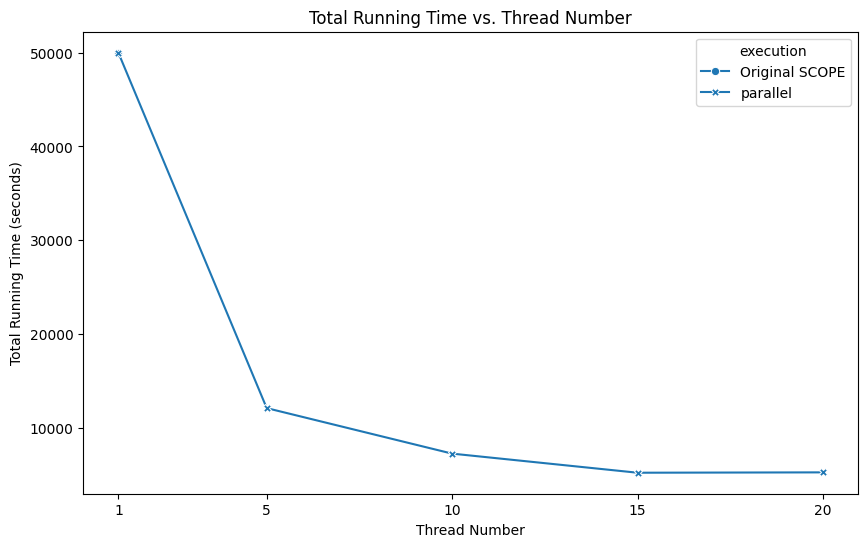

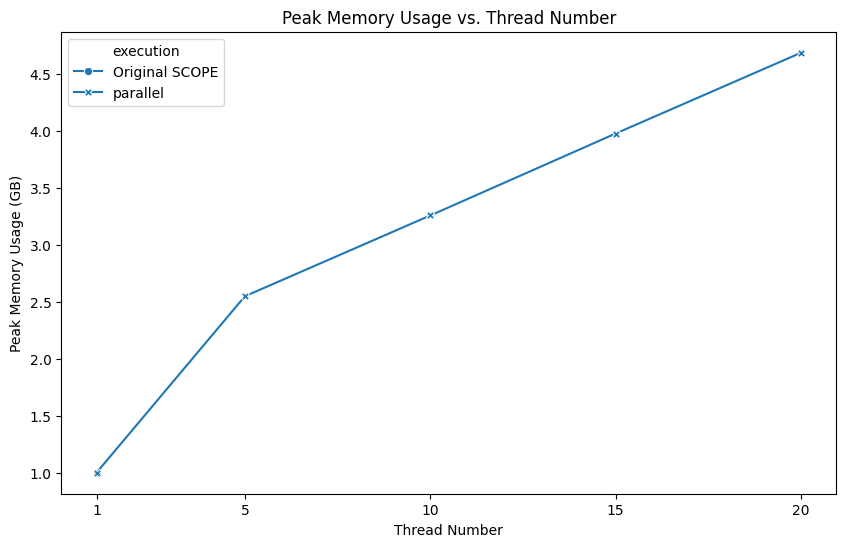

In [6]:
# analyze the results of the SCOPE-parallel
# draw the figure
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

if __name__ == "__main__":
    result = []
    result.append(['Original SCOPE', 1, 50000, 1]) # single-thread
    result.append(['parallel', 1, 50000, 1]) # 1-thread
    result.append(['parallel', 5, 12092, 2.55]) # 5-thread
    result.append(['parallel', 10, 7237, 3.26]) # 10-thread
    result.append(['parallel', 15, 5200, 3.98]) # 15-thread
    result.append(['parallel', 20, 5238, 4.69]) # 20-thread
    df = pd.DataFrame(result, columns=['execution', 'thread_num', 'running_time', 'memory'])

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='thread_num', y='running_time', style='execution', markers=True, dashes=False)
    plt.title('Total Running Time vs. Thread Number')
    plt.xlabel('Thread Number')
    plt.ylabel('Total Running Time (seconds)')
    plt.xticks(ticks=df['thread_num'].unique())  # Setting ticks to only the unique thread numbers in the data
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='thread_num', y='memory', style='execution', markers=True, dashes=False)
    plt.title('Peak Memory Usage vs. Thread Number')
    plt.xlabel('Thread Number')
    plt.ylabel('Peak Memory Usage (GB)')
    plt.xticks(ticks=df['thread_num'].unique())  # Setting ticks to only the unique thread numbers in the data
    plt.show()